In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

### Download a dataset

In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


In [3]:
num_classes = metadata.features['label'].num_classes
print(num_classes)


5


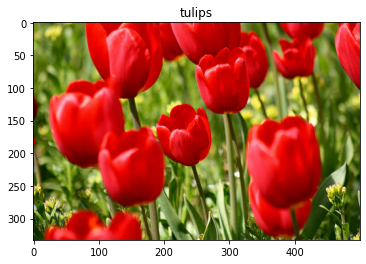

In [4]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


### Resizing and rescaling

In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])


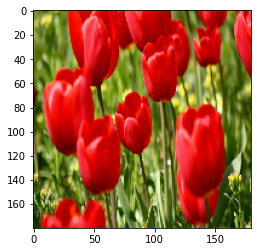

In [6]:
result = resize_and_rescale(image)
_ = plt.imshow(result)


#### You can verify the pixels are in [0-1]

In [7]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())


Min and max pixel values: 0.0 1.0


### Data augmentation

You can use preprocessing layers for data augmentation as well.

Let's create a few preprocessing layers and apply them repeatedly to the same image.

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [9]:
# Add the image to a batch
image = tf.expand_dims(image, 0)


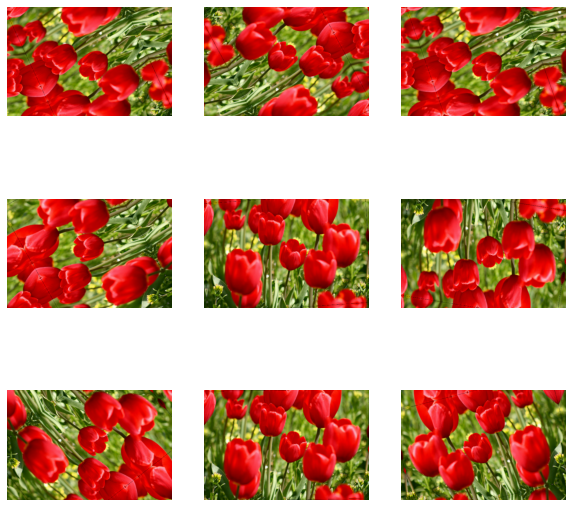

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")


### Make the preprocessing layers part of your model

In [11]:
model = tf.keras.Sequential([
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model
])


### Apply the preprocessing layers to your dataset

In [12]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))


In [13]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)


In [14]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)


### Train a model

In [15]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/5
92/92 [==============================] - 48s 526ms/step - loss: 1.4062 - accuracy: 0.3886 - val_loss: 1.1568 - val_accuracy: 0.5804
Epoch 2/5
92/92 [==============================] - 49s 534ms/step - loss: 1.1137 - accuracy: 0.5511 - val_loss: 1.0644 - val_accuracy: 0.5613
Epoch 3/5
92/92 [==============================] - 49s 535ms/step - loss: 1.0249 - accuracy: 0.5851 - val_loss: 0.9385 - val_accuracy: 0.6485
Epoch 4/5
92/92 [==============================] - 47s 515ms/step - loss: 0.9480 - accuracy: 0.6226 - val_loss: 0.8985 - val_accuracy: 0.6676
Epoch 5/5
92/92 [==============================] - 48s 517ms/step - loss: 0.8967 - accuracy: 0.6505 - val_loss: 0.9267 - val_accuracy: 0.6649


In [18]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)


12/12 [==============================] - 1s 125ms/step - loss: 0.9255 - accuracy: 0.6349
Accuracy 0.6348773837089539


### Custom data augmentation

In [19]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [20]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()


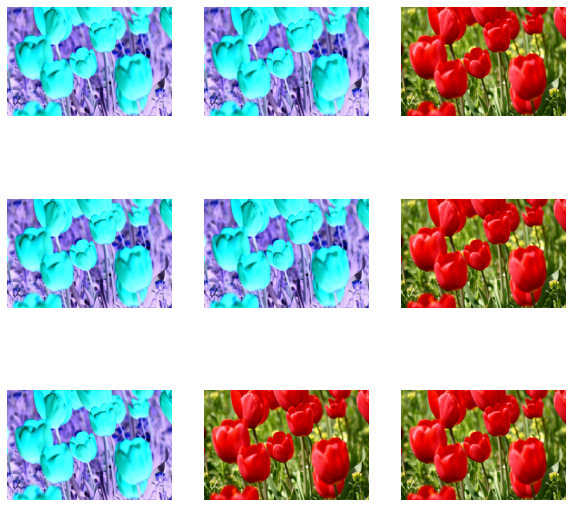

In [21]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")


### Next, implement a custom layer by subclassing.

In [22]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)


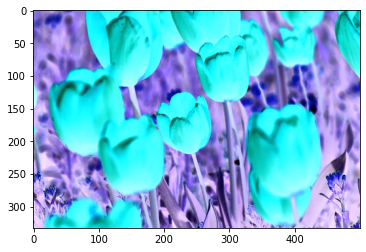

In [23]:
_ = plt.imshow(RandomInvert()(image)[0])


#### Using tf.image

In [24]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)


### Retrieve an image to work with.

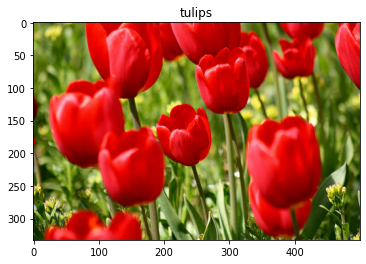

In [25]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))


#### Let's use the following function to visualize and compare the original and augmented images side-by-side.

In [26]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


Data augmentation
Flipping the image

Flip the image either vertically or horizontally.

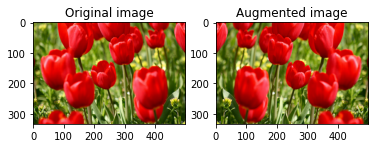

In [27]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)


# Grayscale the image

Grayscale an image

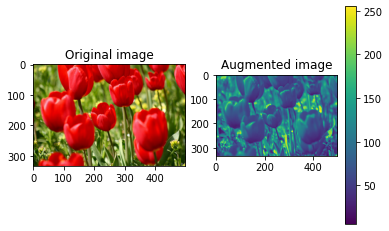

In [28]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()


# Saturate the image

Saturate an image by providing a saturation factor.

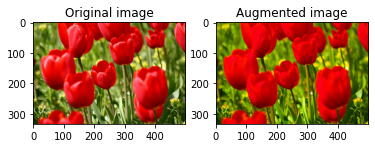

In [29]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)


# Change image brightness

Change the brightness of image by providing a brightness factor.

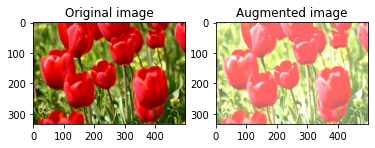

In [30]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)


# Center crop the image

Crop the image from center up to the image part you desire.

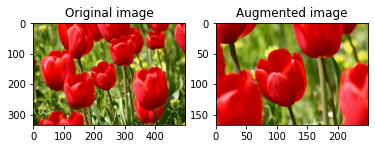

In [31]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image,cropped)


# Rotate the image

Rotate an image by 90 degrees

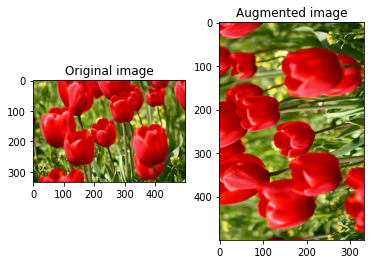

In [32]:
rotated = tf.image.rot90(image)
visualize(image, rotated)


## Apply augmentation to a dataset

As before, apply data augmentation to a dataset using Dataset.map.

In [33]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

In [34]:
def augment(image,label):
  image, label = resize_and_rescale(image, label)
  # Add 6 pixels of padding
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.clip_by_value(image, 0, 1)
  return image, label

### Configure the datasets

In [35]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [36]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


In [37]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
